# Comparative Analysis of Netflix vs Disney+ Catalogs  

**Author:** Luis Santamaría  
**Date:** August 31, 2025  

---

## Objective  
The goal of this project is to analyze and compare the content catalogs of Netflix and Disney+, focusing on total volume, runtime distributions, genre diversity, countries of origin, and temporal trends. The aim is to identify structural differences between the two platforms and provide strategic insights about content positioning.  

This notebook follows a reproducible workflow: we start by importing the necessary libraries and setting up the environment, then proceed to load and validate the datasets, clean and normalize the data, and finally perform exploratory and inferential analysis. Each step is documented with explanations, code, and visualizations.  

---

## Research Questions  
1. How do the runtime distributions differ across platforms?  
2. Which platform has greater diversity in genres and countries of origin?  
3. How has the volume of releases evolved over time?  
4. Which genres represent a relative advantage for each platform?  
5. (If descriptions are available) What themes or topics are more prominent on each platform?  

---

## Working Hypotheses  
- H1: Disney+ will show lower variance in runtime, indicating a more homogeneous, family-oriented catalog.  
- H2: Netflix will exhibit greater diversity of genres and countries, reflecting a broader, exploratory strategy.  

---

## Scope and Limitations (Data Card)  
- **Data source:** Publicly available datasets of Netflix and Disney+ titles (CSV/Parquet prepared beforehand).  
- **Coverage period:** Up to August 31, 2025.  
- **Expected fields:**  
  `title, type, platform, release_year, duration_min, genres, country, description (optional rating)`  
- **Scope:** This analysis is limited to the content offered in the catalogs. It does not measure consumption, audience behavior, or viewership hours.  
- **Limitations:**  
  - Missing or inconsistent values in genres and countries.  
  - Differences in how each platform defines and classifies genres.  
  - Potential absence of content removal dates.  


## 1. Imports — analytical toolkit

We begin by importing the essential Python libraries for this analysis:  
- **pandas**: tabular data manipulation, reading and cleaning CSV/Parquet files, and summarizing datasets.  
- **matplotlib**: high-quality static visualizations for exploratory data analysis and final reporting.  
- **scipy.stats**: statistical tests (e.g., t-test, Mann–Whitney U, Kolmogorov–Smirnov) and distribution analysis.  
- **statsmodels**: advanced statistical modeling and confidence intervals.  

These libraries form the foundation of our workflow, allowing us to handle data frames, perform statistical inference, and create reproducible figures.


In [14]:
!pip install pandas matplotlib scipy statsmodels --quiet

import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

pd.set_option("display.max_colwidth", 150)
plt.rcParams["figure.dpi"] = 120

## 2. Reproducibility — fixed random seed

For transparency and reproducibility, we establish a fixed random seed.  
This guarantees that operations involving randomness (such as bootstrapping or resampling) will yield consistent results every time the notebook is executed, making the analysis auditable and stable.


In [15]:
import os, random, numpy as np

RANDOM_SEED = 42

def set_seed(seed: int = RANDOM_SEED) -> None:
    random.seed(seed)
    np.random.seed(seed)

set_seed()
print(f"Random seed fixed at {RANDOM_SEED}.")

Random seed fixed at 42.


## 3. Project metadata — documenting scope and time

We declare project-level constants to ensure clarity across outputs:  
- **PROJECT_TITLE**: the project’s name, useful for logging and annotations.  
- **AUTHOR**: the notebook’s author.  
- **DATA_CUTOFF**: the date of the last included data, anchoring the analysis in time.  

These values appear in outputs and help readers quickly understand the project context.

In [16]:
PROJECT_TITLE = "Comparative Analysis of Netflix vs Disney+ Catalogs"
AUTHOR        = "Luis Santamaría"
DATA_CUTOFF   = "2025-08-31"

print(f"{PROJECT_TITLE} | Author: {AUTHOR} | Data cutoff: {DATA_CUTOFF}")

Comparative Analysis of Netflix vs Disney+ Catalogs | Author: Luis Santamaría | Data cutoff: 2025-08-31


## 4. Directory structure — organized workflow

We create a minimal but consistent folder structure:  
- **data/**: raw and intermediate datasets.  
- **figures/**: charts and plots generated during the analysis.  
- **docs/**: auxiliary documents (e.g., data card, summaries).  

This separation improves maintainability and ensures that outputs are easy to locate and reuse in reports or dashboards.


In [17]:
ROOT = "."
DATA_DIR = os.path.join(ROOT, "data")
FIG_DIR  = os.path.join(ROOT, "figures")
DOC_DIR  = os.path.join(ROOT, "docs")

for d in (DATA_DIR, FIG_DIR, DOC_DIR):
    os.makedirs(d, exist_ok=True)

print("Directories ready:", DATA_DIR, FIG_DIR, DOC_DIR)

Directories ready: ./data ./figures ./docs


## 5. Figure export utility — consistent outputs

We define a helper function to save all figures consistently in the `figures/` folder.  
This ensures that every visualization is:  
- Saved with a clear and consistent filename.  
- Exported with tight layout to avoid clipped labels.  
- Ready for inclusion in the executive summary or presentation slides.

In [18]:
def save_fig(name: str, ext: str = "png", tight: bool = True) -> str:
    """
    Save the current matplotlib figure to figures/<name>.<ext> with consistent settings.
    Returns the output path for logging.
    """
    if tight:
        plt.tight_layout()
    out_path = os.path.join(FIG_DIR, f"{name}.{ext}")
    plt.savefig(out_path, bbox_inches="tight")
    print(f"[OK] Figure saved: {out_path}")
    return out_path

## 6. Dataset schema

We redefine the expected schema so it matches the raw datasets before normalization.  
Later, during feature engineering, we will derive standardized fields such as `duration_min` and `genres`.  

Expected raw fields are:

- **title**: name of the movie or series  
- **type**: Movie or TV Show  
- **platform**: Netflix or Disney+ (added at load time)  
- **release_year**: year of original release  
- **duration**: runtime string (e.g., "90 min" or "2 Seasons")  
- **listed_in**: categories or genres  
- **country**: country of origin  
- **description**: synopsis (optional: rating and other fields may exist)


In [24]:
EXPECTED_COLS = {
    "title", "type", "platform", "release_year", "duration",
    "listed_in", "country", "description"
}

def assert_columns(df: pd.DataFrame, expected=EXPECTED_COLS):
    missing = expected.difference(df.columns)
    if missing:
        raise ValueError(f"Missing columns: {missing}")

def assert_basic_quality(df: pd.DataFrame):
    if df.empty:
        raise ValueError("DataFrame is empty.")
    if df["title"].isna().any():
        raise ValueError("Null titles detected.")
    if (df["release_year"] < 1900).any():
        raise ValueError("Invalid release_year values detected (<1900).")

## 7. Data paths and loader — platform tagging

We declare the expected file paths for the Netflix and Disney+ datasets.  
To simplify integration, we create a generic loader function:

- Reads either CSV or Parquet format.  
- Adds a **platform** column (Netflix or Disney+) during loading.  
- Returns a standardized DataFrame ready for validation.

In [25]:
NETFLIX_PATH = os.path.join(DATA_DIR, "netflix_titles.csv")
DISNEY_PATH  = os.path.join(DATA_DIR, "disney_plus_titles.csv")

def load_and_tag(path: str, platform_name: str) -> pd.DataFrame:
    """
    Load CSV or Parquet dataset and tag with platform.
    """
    if path.endswith(".csv"):
        df = pd.read_csv(path)
    else:
        df = pd.read_parquet(path)
    df["platform"] = platform_name
    return df


## 8. Loading the datasets

We apply the loader function to both Netflix and Disney+ catalogs.  
At this stage, each dataset retains its original structure but now includes the `platform` column, which will later be used for comparisons.

In [26]:
df_netflix = load_and_tag(NETFLIX_PATH, "Netflix")
df_disney  = load_and_tag(DISNEY_PATH, "Disney+")

print("Netflix dataset shape:", df_netflix.shape)
print("Disney+ dataset shape:", df_disney.shape)

Netflix dataset shape: (8807, 13)
Disney+ dataset shape: (1450, 13)


## 9. Concatenation into a unified DataFrame

For the comparative analysis, we combine both catalogs into a single DataFrame.  
This approach allows us to perform descriptive and inferential statistics across platforms within the same structure.

In [27]:
df = pd.concat([df_netflix, df_disney], ignore_index=True)
print("Combined dataset shape:", df.shape)
df.head(3)

Combined dataset shape: (10257, 13)


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,platform
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevi...",Netflix
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy ...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.",Netflix
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.",Netflix


## 10. Initial integrity checks

With the unified DataFrame in place, we validate its structure against the expected schema and run basic quality checks.  
This ensures the dataset is complete and ready for cleaning and normalization.

In [28]:
assert_columns(df)
assert_basic_quality(df)
print("[OK] Schema and quality checks passed.")

[OK] Schema and quality checks passed.


## 11. Feature engineering — parse `duration` with dataset-specific conventions

We inspected the raw data and confirmed consistent formatting:
- Movies: strings like `"90 min"` (lowercase `min`).
- TV shows: `"1 Season"` or `"2 Seasons"` (capitalized).

Given this consistency, we use straightforward parsing:
- `duration_min`: numeric minutes for movies; `NaN` for TV shows.
- `seasons_n`: numeric seasons for TV shows; `NaN` for movies.

This keeps the code clear and sufficient for this dataset.


In [36]:
import numpy as np
import pandas as pd

def extract_minutes(x: str):
    if isinstance(x, str) and "min" in x:
        return pd.to_numeric(x.split()[0], errors="coerce")
    return np.nan

def extract_seasons(x: str):
    if isinstance(x, str) and "Season" in x:
        return pd.to_numeric(x.split()[0], errors="coerce")
    return np.nan

df["duration_min"] = df["duration"].apply(extract_minutes)
df["seasons_n"]    = df["duration"].apply(extract_seasons)

is_movie = df["type"].astype(str).str.strip().str.lower().eq("movie")
is_show  = df["type"].astype(str).str.strip().str.lower().isin(["tv show", "tvshow", "show"])

df.loc[is_movie, "seasons_n"]    = np.nan
df.loc[is_show,  "duration_min"] = np.nan

df[["type","duration","duration_min","seasons_n"]].head(5)

,type,duration,duration_min,seasons_n
0,Movie,90 min,90.0,NaN
1,TV Show,2 Seasons,NaN,2.0
2,TV Show,1 Season,NaN,1.0
3,TV Show,1 Season,NaN,1.0
4,TV Show,2 Seasons,NaN,2.0


**Note on missing values (personal observation):**  
When I reviewed the output of this step, I noticed that 3 Netflix stand-up specials  
(*Louis C.K. 2017*, *Louis C.K.: Hilarious*, *Louis C.K.: Live at the Comedy Store*)  
had the `duration` field missing in the raw dataset (`NaN`).  

I decided not to impute these values and to keep them as missing,  
since the dataset itself does not provide reliable runtime metadata.  
This means these titles will be excluded from runtime distributions,  
and I report this here explicitly for transparency.

## 12. Type- and year-cleaning — consistent dtypes

We standardize `type` values and clean `release_year`:
- Normalize `type` to `"Movie"` and `"TV Show"`.
- Coerce `release_year` to integers and clip implausible values to a safe range.
- Create `decade` for temporal aggregation.

This ensures consistent grouping and time-series summaries.

In [37]:
# Normalize 'type'
df["type"] = df["type"].astype(str).str.strip().str.title()
df["type"] = df["type"].replace({"Tv Show": "TV Show"})

# Coerce and bound release_year
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce")
df = df[df["release_year"].between(1900, 2035)]

# Derive decade
df["decade"] = (df["release_year"] // 10) * 10

df[["type","release_year","decade"]].head(5)


,type,release_year,decade
0,Movie,2020,2020
1,TV Show,2021,2020
2,TV Show,2021,2020
3,TV Show,2021,2020
4,TV Show,2021,2020


## 13. Genres normalization — rename and tokenize

We standardize the genres field by:
- Renaming `listed_in` → `genres` for clarity.
- Splitting comma-separated genres into `genres_list`.
- Deriving `primary_genre` (first token) and `genre_count` (token count).

In [38]:
df = df.rename(columns={"listed_in": "genres"})

def split_clean_genres(s):
    if pd.isna(s):
        return []
    return [t.strip() for t in str(s).split(",") if t.strip()]

df["genres_list"]   = df["genres"].apply(split_clean_genres)
df["primary_genre"] = df["genres_list"].apply(lambda xs: xs[0] if xs else np.nan)
df["genre_count"]   = df["genres_list"].apply(len)

df[["genres","genres_list","primary_genre","genre_count"]].head(5)

,genres,genres_list,primary_genre,genre_count
0,Documentaries,[Documentaries],Documentaries,1
1,"International TV Shows, TV Dramas, TV Mysteries","[International TV Shows, TV Dramas, TV Mysteries]",International TV Shows,3
2,"Crime TV Shows, International TV Shows, TV Action & Adventure","[Crime TV Shows, International TV Shows, TV Action & Adventure]",Crime TV Shows,3
3,"Docuseries, Reality TV","[Docuseries, Reality TV]",Docuseries,2
4,"International TV Shows, Romantic TV Shows, TV Comedies","[International TV Shows, Romantic TV Shows, TV Comedies]",International TV Shows,3


## 14. Country normalization — first-country heuristic and explicit missing

We keep a reproducible, transparent policy:
- `country_primary`: first country token from `country` (trimmed).
- We do **not** drop rows with missing country; instead:
  - `has_country`: boolean flag.
  - `country_primary_filled`: missing values labeled as `"Unknown"` for count-based summaries.

This avoids bias while keeping totals correct in platform- and type-level counts.

In [39]:
import numpy as np

def country_first(s):
    if pd.isna(s):
        return np.nan
    first = str(s).split(",")[0].strip()
    return first if first else np.nan

df["country_primary"] = df["country"].apply(country_first)
df["has_country"] = df["country_primary"].notna()
df["country_primary_filled"] = df["country_primary"].fillna("Unknown")

# Quick missingness snapshot
missing_rate = df["country_primary"].isna().mean()
print(f"Missing rate (country_primary): {missing_rate:.2%}")
df[["country","country_primary","country_primary_filled"]].head(5)

Missing rate (country_primary): 10.26%


,country,country_primary,country_primary_filled
0,United States,United States,United States
1,South Africa,South Africa,South Africa
2,NaN,NaN,Unknown
3,NaN,NaN,Unknown
4,India,India,India


**Note on missing countries (personal observation):**  
Around 10% of the titles lack country information in the dataset.  
Instead of dropping them, I kept these rows and labeled them as `"Unknown"`.  
This ensures that total counts remain consistent across platforms,  
while still being transparent about metadata gaps.

## 15. Integrity re-check — validate standardized expectations

After feature engineering, we validate the standardized schema and basic quality:
- Standardized columns include `duration_min` and `genres`.
- Titles must be non-null.
- Release years must be reasonable.

We also report non-null counts of key engineered fields to confirm they are populated.

In [40]:
# Standardized schema for post-FE data
EXPECTED_STD = {
    "title","type","platform","release_year",
    "duration_min","genres","country","description"
}

def assert_columns_std(df: pd.DataFrame):
    missing = EXPECTED_STD.difference(df.columns)
    if missing:
        raise ValueError(f"[STD] Missing columns: {missing}")

def assert_basic_quality_current(df: pd.DataFrame):
    if df.empty:
        raise ValueError("DataFrame is empty.")
    if df["title"].isna().any():
        raise ValueError("Null titles detected.")
    if (pd.to_numeric(df["release_year"], errors="coerce") < 1900).any():
        raise ValueError("Invalid release_year values detected (<1900).")

# Run validations
assert_columns_std(df)
assert_basic_quality_current(df)

# Engineered field presence and simple population checks
key_cols = ["duration_min","seasons_n","primary_genre","country_primary"]
print("Non-null counts (key engineered fields):")
print(df[key_cols].notna().sum().to_string())

# Quick platform/type snapshot
display(
    df.groupby(["platform","type"]).size().rename("n").reset_index().sort_values(["platform","type"])
)

Non-null counts (key engineered fields):
duration_min        7180
seasons_n           3074
primary_genre      10257
country_primary     9205


,platform,type,n
0,Disney+,Movie,1052
1,Disney+,TV Show,398
2,Netflix,Movie,6131
3,Netflix,TV Show,2676


In [41]:
# 1) Audit: movies missing duration_min (should be only 3)
is_movie = df["type"].astype(str).str.strip().str.lower().eq("movie")
movies_missing_min = df[is_movie & df["duration_min"].isna()][["title","platform","duration"]]
print(f"Movies with missing minutes: {len(movies_missing_min)}")
display(movies_missing_min.head(10))
print("Unique raw 'duration' values among these:")
display(movies_missing_min["duration"].value_counts(dropna=False).head(20))


Movies with missing minutes: 3


,title,platform,duration
5541,Louis C.K. 2017,Netflix,NaN
5794,Louis C.K.: Hilarious,Netflix,NaN
5813,Louis C.K.: Live at the Comedy Store,Netflix,NaN


Unique raw 'duration' values among these:


,count
duration,
NaN,3


## 16. Descriptive EDA — basic distributions and counts  

Before diving into platform comparisons, I first explore the dataset globally.  
The aim is to understand the distribution of movies and TV shows, and to check whether the engineered variables (`duration_min`, `seasons_n`) behave as expected.  

I focus on:  
- Counts of Movies vs TV Shows.  
- Distribution of runtimes for Movies (`duration_min`).  
- Distribution of number of seasons for TV Shows (`seasons_n`).  

This provides a first validation of the data and sets the stage for platform-level comparisons.  

Counts by type:
type
Movie      7183
TV Show    3074
Name: count, dtype: int64


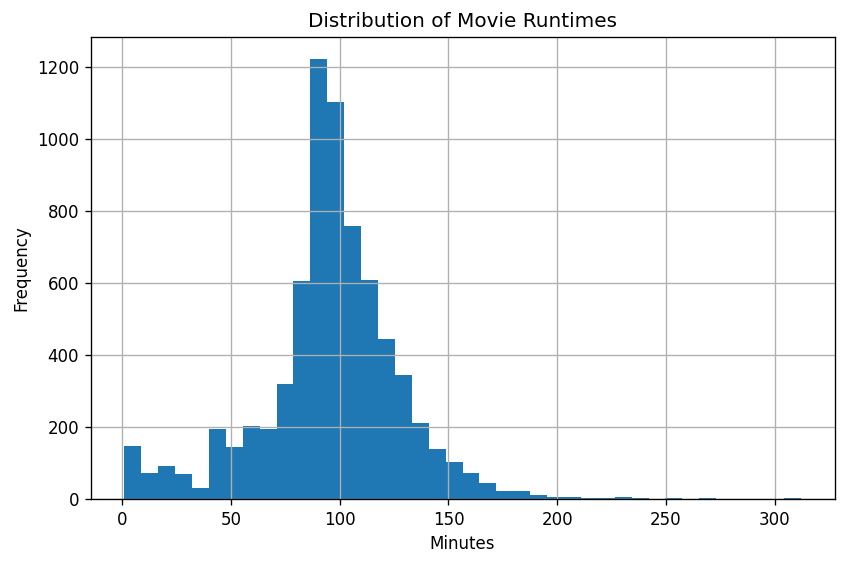

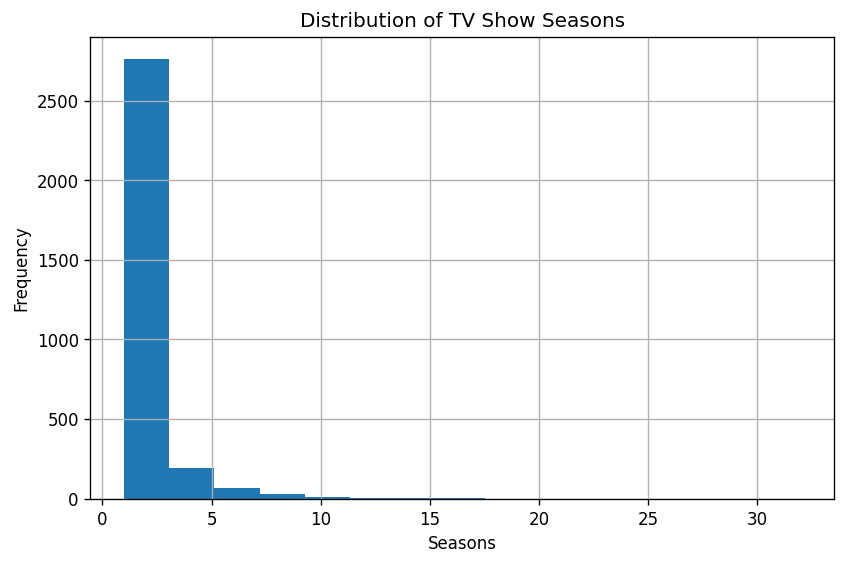

In [42]:
import matplotlib.pyplot as plt

# --- Counts of Movies vs TV Shows ---
counts_type = df["type"].value_counts()
print("Counts by type:")
print(counts_type)

# --- Distribution of runtimes (Movies only) ---
movies = df[df["type"] == "Movie"]
plt.figure(figsize=(8,5))
movies["duration_min"].dropna().hist(bins=40)
plt.title("Distribution of Movie Runtimes")
plt.xlabel("Minutes")
plt.ylabel("Frequency")
plt.show()

# --- Distribution of seasons (TV Shows only) ---
shows = df[df["type"] == "TV Show"]
plt.figure(figsize=(8,5))
shows["seasons_n"].dropna().hist(bins=15)
plt.title("Distribution of TV Show Seasons")
plt.xlabel("Seasons")
plt.ylabel("Frequency")
plt.show()

**Key Findings:**  
- 7,183 Movies vs 3,074 TV Shows.  
- Movie runtimes cluster between 80–120 minutes, with shorts (<40) and long documentaries (>200) as outliers.  
- TV Shows are concentrated in 1–3 seasons, few beyond 10.  

## 17. Platform-level comparison  

Having validated the dataset globally, I now compare Netflix and Disney+ catalogs directly.  
This step provides a first look at structural differences between the two platforms, focusing on:  

- Total volume of titles per platform.  
- Proportions of Movies vs TV Shows.  
- Median runtime for Movies and median number of seasons for TV Shows.  

These comparisons establish the baseline for platform positioning:  
Disney+ as a family-oriented, curated library vs. Netflix as a broader, more diverse catalog.  

Counts by platform:
platform
Disney+    1450
Netflix    8807
Name: title, dtype: int64

Movies vs TV Shows per platform:
type      Movie  TV Show
platform                
Disney+    1052      398
Netflix    6131     2676

Median runtime for Movies:
platform
Disney+    85.0
Netflix    98.0
Name: duration_min, dtype: float64

Median number of seasons for TV Shows:
platform
Disney+    1.0
Netflix    1.0
Name: seasons_n, dtype: float64


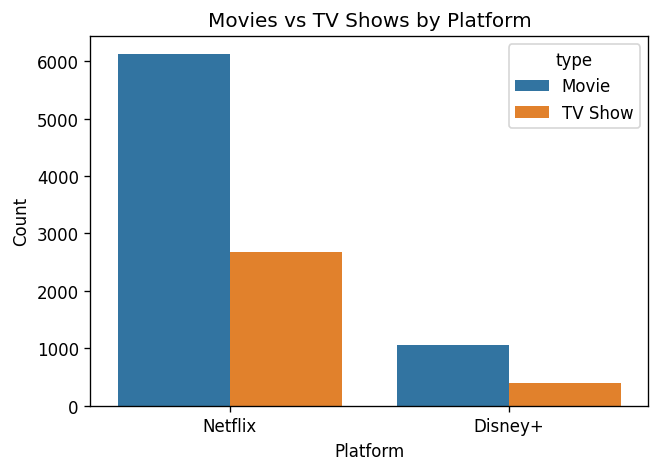

In [44]:
import seaborn as sns

# --- Counts by platform ---
counts_platform = df.groupby("platform")["title"].count()
print("Counts by platform:")
print(counts_platform)

# --- Movies vs TV Shows per platform ---
counts_type_platform = df.groupby(["platform","type"]).size().unstack(fill_value=0)
print("\nMovies vs TV Shows per platform:")
print(counts_type_platform)

# --- Median runtimes (Movies only) ---
median_runtime = df[df["type"]=="Movie"].groupby("platform")["duration_min"].median()
print("\nMedian runtime for Movies:")
print(median_runtime)

# --- Median seasons (TV Shows only) ---
median_seasons = df[df["type"]=="TV Show"].groupby("platform")["seasons_n"].median()
print("\nMedian number of seasons for TV Shows:")
print(median_seasons)

# --- Quick barplot: Movies vs TV Shows per platform ---
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="platform", hue="type")
plt.title("Movies vs TV Shows by Platform")
plt.xlabel("Platform")
plt.ylabel("Count")
plt.show()

**Key Findings:**  
- Netflix has a much larger catalog (8,807 titles) compared to Disney+ (1,450 titles).  
- Disney+ is heavily weighted toward Movies (1,052 out of 1,450, ~73%), while Netflix maintains a more balanced mix of Movies (6,131) and TV Shows (2,676).  
- The median runtime for Movies is slightly lower on Disney+ (85 min) than on Netflix (98 min), reflecting Disney+’s focus on family-friendly, standardized lengths.  
- Both platforms have a median of 1 season per TV Show, but Netflix hosts a much larger number of long-running series.  

## 18. Temporal trends — releases over time

Next, I analyze how each catalog evolved over time.  
I focus on yearly counts (overall and by platform) and on separate trends for Movies vs TV Shows.  
This helps reveal expansion phases, catalog maturity, and whether one platform grew faster in specific periods.

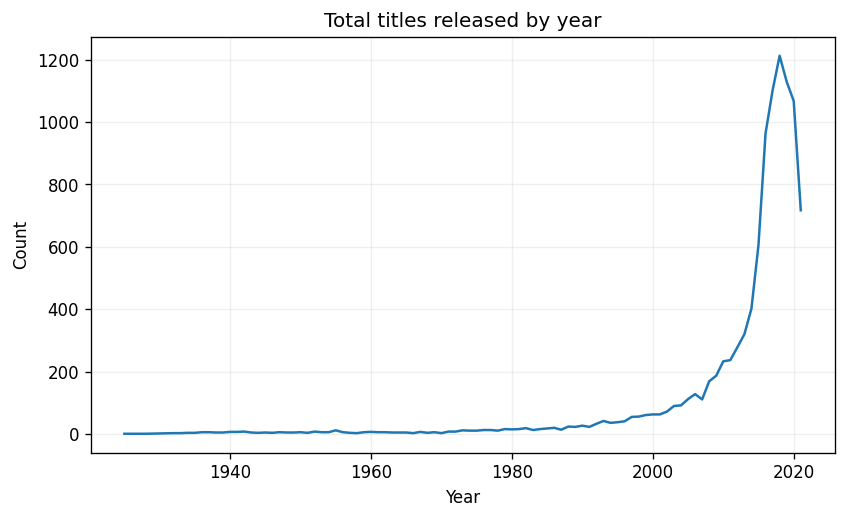

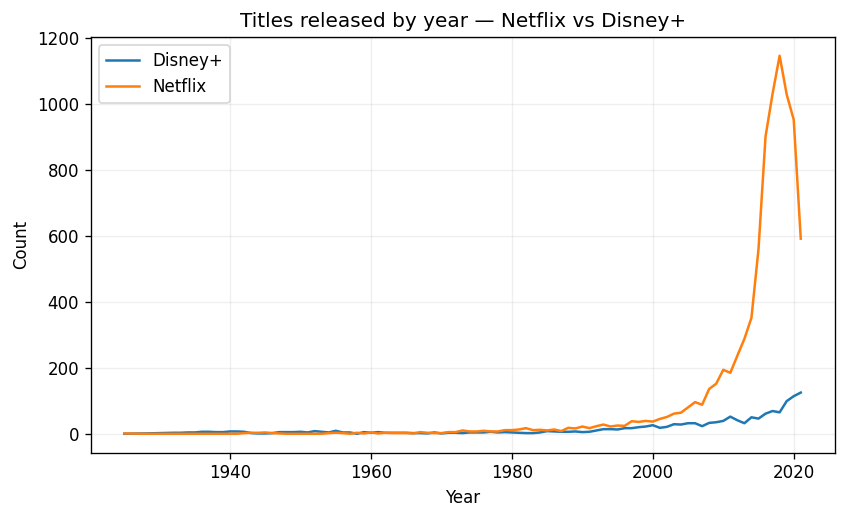

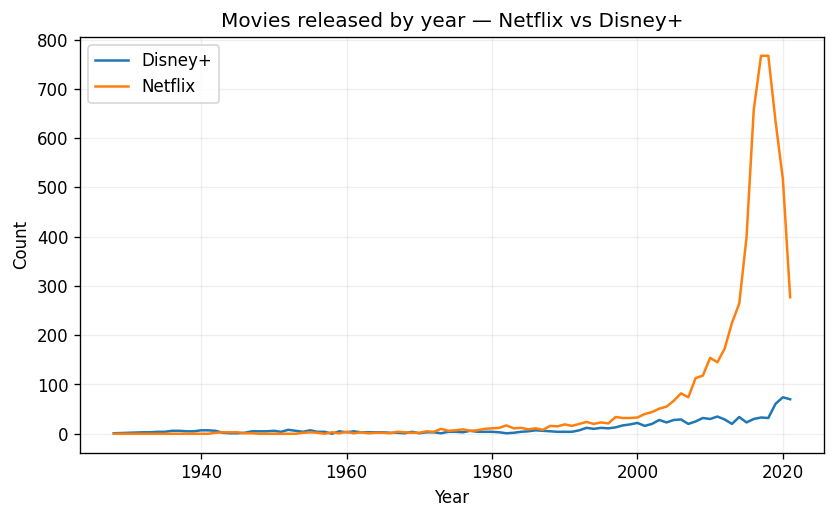

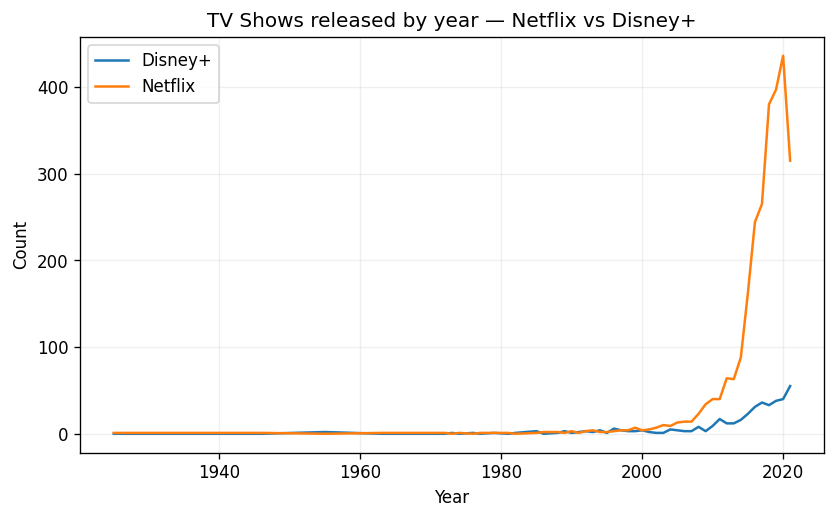

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Overall releases by year ---
by_year = df.groupby("release_year").size().rename("n").reset_index()

plt.figure(figsize=(8,4.5))
plt.plot(by_year["release_year"], by_year["n"], marker="", linewidth=1.5)
plt.title("Total titles released by year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True, alpha=0.2)
plt.show()

# --- Releases by year and platform ---
by_year_plat = (
    df.groupby(["release_year","platform"])
      .size().rename("n").reset_index()
      .pivot(index="release_year", columns="platform", values="n")
      .fillna(0)
)

plt.figure(figsize=(8,4.5))
for col in by_year_plat.columns:
    plt.plot(by_year_plat.index, by_year_plat[col], label=col, linewidth=1.5)
plt.title("Titles released by year — Netflix vs Disney+")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# --- Split by type: Movies vs TV Shows (per platform) ---
by_year_type_plat = (
    df.groupby(["release_year","platform","type"])
      .size().rename("n").reset_index()
)

# Movies
movies_year = (
    by_year_type_plat[by_year_type_plat["type"]=="Movie"]
    .pivot(index="release_year", columns="platform", values="n")
    .fillna(0)
)
plt.figure(figsize=(8,4.5))
for col in movies_year.columns:
    plt.plot(movies_year.index, movies_year[col], label=col, linewidth=1.5)
plt.title("Movies released by year — Netflix vs Disney+")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

# TV Shows
shows_year = (
    by_year_type_plat[by_year_type_plat["type"]=="TV Show"]
    .pivot(index="release_year", columns="platform", values="n")
    .fillna(0)
)
plt.figure(figsize=(8,4.5))
for col in shows_year.columns:
    plt.plot(shows_year.index, shows_year[col], label=col, linewidth=1.5)
plt.title("TV Shows released by year — Netflix vs Disney+")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

### Key Findings – Temporal Trends
- Netflix shows explosive growth in releases after 2010, peaking around 2018–2019.  
- Disney+ entries only appear from 2019 onward, with a modest but growing contribution.  
- Movies dominate the catalogs historically, but TV Shows also surged in recent years, especially on Netflix.  
- The drop observed after 2020 likely reflects incomplete or missing metadata in the dataset, not an actual market decline.  

## 19. Decade-level aggregation

Yearly counts are sensitive to fluctuations and missing metadata in the most recent years.  
To smooth this and enable long-term comparisons, we aggregate releases by **decade**:

- Each title is assigned to its release decade (e.g., 1990s, 2000s, 2010s).  
- We compute counts by decade, by platform, and by type (Movie vs TV Show).  
- This highlights structural differences: Netflix is concentrated in the 2010s–2020s, while Disney+ inherits titles spanning multiple decades.

Table 1 — Raw counts per decade, platform, and type


,decade,platform,type,count
0,1920,Disney+,Movie,1
1,1920,Netflix,TV Show,1
2,1930,Disney+,Movie,36
3,1940,Disney+,Movie,41
4,1940,Netflix,Movie,13
5,1940,Netflix,TV Show,2
6,1950,Disney+,Movie,48
7,1950,Disney+,TV Show,2
8,1950,Netflix,Movie,11
9,1960,Disney+,Movie,29



Table 2 — Pivot table of counts per decade (Movies vs TV Shows by platform)


platform Disney+         Netflix        
type       Movie TV Show   Movie TV Show
decade                                  
1920         1.0     0.0     0.0     1.0
1930        36.0     0.0     0.0     0.0
1940        41.0     0.0    13.0     2.0
1950        48.0     2.0    11.0     0.0
1960        29.0     0.0    23.0     2.0
1970        33.0     3.0    66.0     4.0
1980        41.0     8.0   122.0     7.0
1990       109.0    29.0   241.0    33.0
2000       243.0    34.0   677.0   133.0
2010       327.0   227.0  4184.0  1743.0
2020       144.0    95.0   794.0   751.0

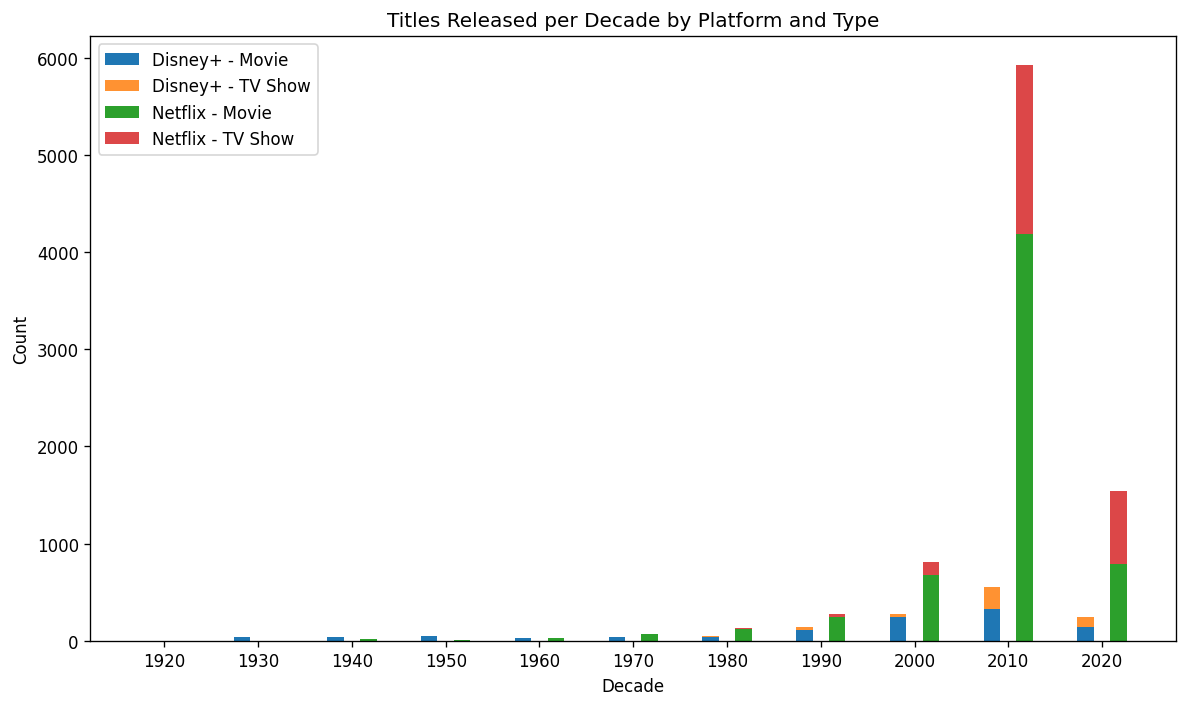

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate by decade
decade_counts = (
    df.groupby(["decade", "platform", "type"])
      .size()
      .reset_index(name="count")
      .sort_values(["decade","platform","type"])
)

# Pivot for side-by-side comparison
pivot_decade = (
    decade_counts.pivot_table(
        index="decade",
        columns=["platform","type"],
        values="count",
        fill_value=0
    )
    .sort_index()
)

# ---- Subtítulos antes de cada tabla ----
print("Table 1 — Raw counts per decade, platform, and type")
display(decade_counts.head(12))  # cambia a display(decade_counts) si quieres toda la tabla

print("\nTable 2 — Pivot table of counts per decade (Movies vs TV Shows by platform)")
display(pivot_decade)

# ---- Chart: grouped bars by decade and platform/type (mismo gráfico) ----
plt.figure(figsize=(10,6))

width = 0.35
decades = sorted(decade_counts["decade"].unique())
x = range(len(decades))

def series_for(platform, ttype):
    s = decade_counts.query("platform == @platform and type == @ttype") \
                     .set_index("decade")["count"]
    return [s.get(d, 0) for d in decades]

# Disney+
plt.bar([i - width/2 for i in x], series_for("Disney+", "Movie"), width=width*0.5, label="Disney+ - Movie")
plt.bar([i - width/2 for i in x], series_for("Disney+", "TV Show"),
        bottom=series_for("Disney+", "Movie"), width=width*0.5, label="Disney+ - TV Show", alpha=0.85)

# Netflix
plt.bar([i + width/2 for i in x], series_for("Netflix", "Movie"), width=width*0.5, label="Netflix - Movie")
plt.bar([i + width/2 for i in x], series_for("Netflix", "TV Show"),
        bottom=series_for("Netflix", "Movie"), width=width*0.5, label="Netflix - TV Show", alpha=0.85)

plt.title("Titles Released per Decade by Platform and Type")
plt.xlabel("Decade")
plt.ylabel("Count")
plt.xticks(list(x), [str(d) for d in decades])
plt.legend()
plt.tight_layout()
plt.show()


### Key Findings — Titles Released per Decade

- **Disney+ historical depth**: Even though Disney+ launched as a streaming service in 2019, its catalog integrates legacy Disney titles from as early as the 1920s. This explains the presence of movies in decades long before the platform’s existence.  
- **Netflix growth**: Netflix’s catalog is overwhelmingly concentrated in the 2000s and 2010s, with a massive spike during the 2010s (over 5,900 titles). This reflects its aggressive expansion strategy after moving into original content around 2013.  
- **Movies vs TV shows**: Netflix consistently prioritizes movies, but its TV shows also exploded in the 2010s, reflecting the “binge-watching” model that distinguished the platform.  
- **Disney+ consistency**: Disney+ shows more stable movie releases across decades, aligned with the long-standing Disney studio pipeline, while TV shows only became notable in the last few decades.  
- **Strategic implication**: Netflix’s rapid growth has been volume-driven, while Disney+ leverages legacy catalog depth plus selective expansions, especially through franchises.

## 20. Genre analysis — distributions and relative advantages

I compare Netflix vs Disney+ across genres to see *where each platform over-indexes*.  
I do three things:
- Overall and per-platform counts of `primary_genre`.
- A simple **diversity** snapshot (unique genres, average `genre_count` per title).
- A **lift** metric:  Lift(genre, platform) = P(genre | platform) / P(genre overall).  
  Values > 1 → the platform features that genre more than the market baseline.

Table 1 — Overall primary-genre counts (top 15)


,count_overall
primary_genre,
Dramas,1600
Comedies,1210
Action & Adventure,859
Documentaries,829
International TV Shows,774
Children & Family Movies,605
Action-Adventure,452
Crime TV Shows,399
Kids' TV,388



Table 2 — Primary-genre counts by platform (top 15 overall order)


platform,Disney+,Netflix
primary_genre,,
Dramas,0,1600
Comedies,0,1210
Action & Adventure,0,859
Documentaries,0,829
International TV Shows,0,774
Children & Family Movies,0,605
Action-Adventure,452,0
Crime TV Shows,0,399
Kids' TV,0,388



Table 3 — Diversity snapshot per platform


,unique_primary_genres,avg_genre_count
platform,,
Disney+,29,2.697
Netflix,36,2.194



Table 4 — Top-10 genres by lift (relative advantage) — Disney+


,lift
primary_genre,
Action-Adventure,7.07
Animals & Nature,7.07
Animation,7.07
Anthology,7.07
Buddy,7.07
Comedy,7.07
Coming of Age,7.07
Documentary,7.07
Crime,7.07



Table 5 — Top-10 genres by lift (relative advantage) — Netflix


,lift
primary_genre,
Action & Adventure,1.16
Anime Series,1.16
Anime Features,1.16
Classic & Cult TV,1.16
Classic Movies,1.16
Children & Family Movies,1.16
British TV Shows,1.16
Comedies,1.16
Horror Movies,1.16


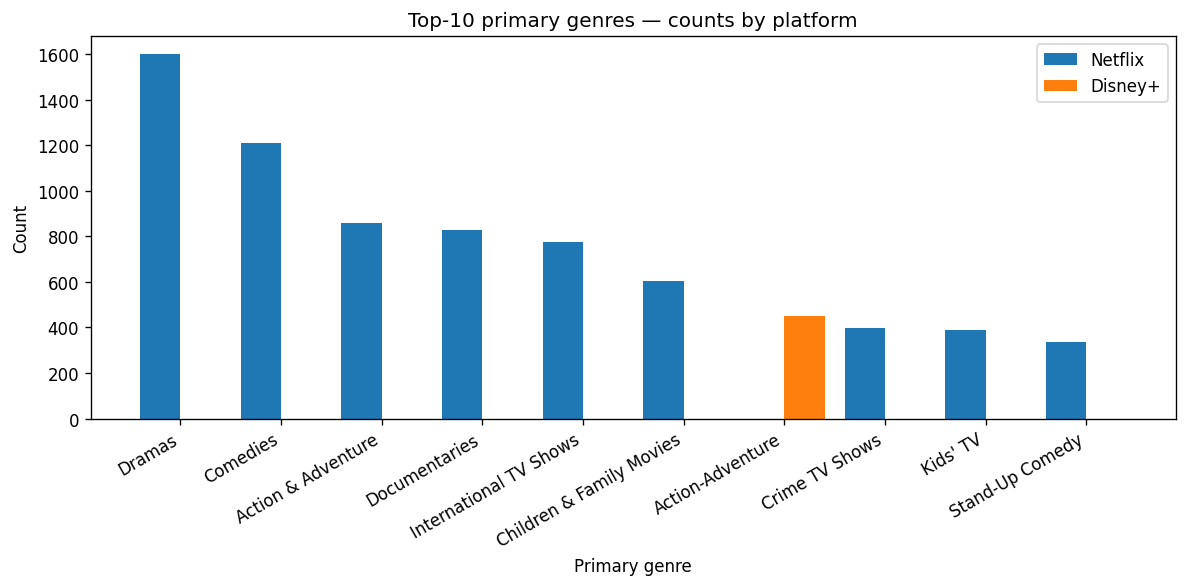

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Primary-genre counts (overall and by platform) ---
g_overall = df["primary_genre"].value_counts().rename("count_overall")
g_platform = (
    df.groupby(["platform","primary_genre"])
      .size().rename("count").reset_index()
      .pivot(index="primary_genre", columns="platform", values="count")
      .fillna(0).astype(int)
)

print("Table 1 — Overall primary-genre counts (top 15)")
display(g_overall.head(15).to_frame())

print("\nTable 2 — Primary-genre counts by platform (top 15 overall order)")
top15 = g_overall.head(15).index
display(g_platform.loc[top15])

# --- 2) Diversity snapshot ---
diversity = (
    df.groupby("platform")
      .agg(unique_primary_genres=("primary_genre", lambda s: s.dropna().nunique()),
           avg_genre_count=("genre_count","mean"))
      .round(3)
)
print("\nTable 3 — Diversity snapshot per platform")
display(diversity)

# --- 3) Lift calculation (relative advantage) ---
total_titles = len(df)
p_genre = g_overall / total_titles  # P(genre) overall

# counts per platform
counts_plat = df["platform"].value_counts()
lifts = {}
for plat in counts_plat.index:
    # P(genre|platform)
    p_genre_given_plat = (g_platform[plat] / counts_plat[plat]).fillna(0)
    lift_plat = (p_genre_given_plat / p_genre).replace([np.inf, -np.inf], np.nan)
    lifts[plat] = lift_plat.sort_values(ascending=False)

# show top-10 lifts for each platform
print("\nTable 4 — Top-10 genres by lift (relative advantage) — Disney+")
display(lifts["Disney+"].dropna().head(10).to_frame("lift").round(2))

print("\nTable 5 — Top-10 genres by lift (relative advantage) — Netflix")
display(lifts["Netflix"].dropna().head(10).to_frame("lift").round(2))

# --- 4) Quick bar chart: top-10 overall with platform split ---
top10 = g_overall.head(10).index
data_plot = g_platform.loc[top10]

plt.figure(figsize=(10,5))
x = np.arange(len(top10))
width = 0.4
plt.bar(x - width/2, data_plot["Netflix"].values, width, label="Netflix")
plt.bar(x + width/2, data_plot["Disney+"].values, width, label="Disney+")
plt.xticks(x, top10, rotation=30, ha="right")
plt.title("Top-10 primary genres — counts by platform")
plt.xlabel("Primary genre")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


### Key Findings — Genres Analysis

- **Concentration on Netflix:** The most frequent genres are *Dramas* and *Comedies*, each with more than 1,000 titles, indicating a catalog heavily oriented toward narrative variety.  
- **Disney+ specialization:** While Disney+ has fewer unique genres than Netflix (29 vs 36), it strongly emphasizes *Action-Adventure* and *Animation*, aligned with its family-oriented brand strategy.  
- **Relative diversity:** Netflix offers more unique genres overall, but Disney+ shows a higher average number of titles per genre, reflecting a more concentrated focus.  
- **Competitive edge:**  
  - Disney+ exhibits a relative advantage in *Animation*, *Action-Adventure*, and *Family-oriented genres*.  
  - Netflix dominates in *Drama*, *Comedies*, and *International TV Shows*, reinforcing its global profile.


## 21. Ratings Analysis

This step examines the maturity ratings of titles to understand how family-oriented or adult-oriented each platform is.  

We will:  
- Normalize rating labels to make them consistent (e.g., merge `TV-G`, `TBG` → `G` / General Audience).  
- Display frequency tables of ratings overall and by platform.  
- Provide a diversity snapshot: number of distinct rating categories per platform.  
- Visualize the distribution of ratings across Netflix and Disney+.

,rating,count_overall
0,Mature,4089
1,G,3075
2,Teen,2239
3,Other,847
4,Unknown,7


platform,Disney+,Netflix
rating_norm,,
Mature,0,4089
G,1174,1901
Teen,79,2160
Other,194,653
Unknown,3,4


,platform,unique_ratings
0,Disney+,4
1,Netflix,5


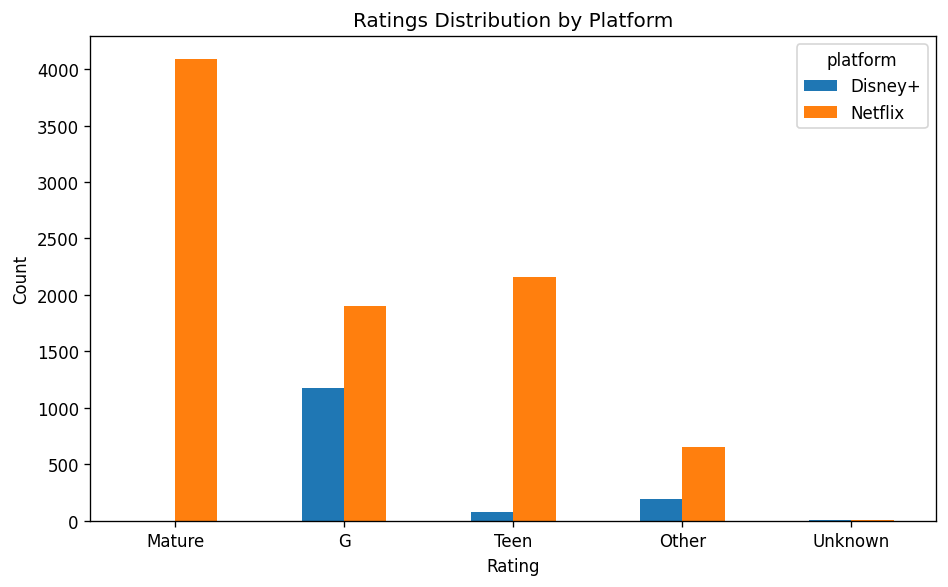

In [51]:
import re
import matplotlib.pyplot as plt

# --- 1) Normalize ratings ---
def normalize_rating(r):
    if pd.isna(r):
        return "Unknown"
    r = str(r).upper().strip()
    # General Audience
    if re.search(r"(TV-G|TBG|G|GENERAL)", r):
        return "G"
    # Parental Guidance
    if re.search(r"(TV-PG|PG|TBGPS)", r):
        return "PG"
    # Teens
    if re.search(r"(TV-14|PG-13|14)", r):
        return "Teen"
    # Mature
    if re.search(r"(TV-MA|R|18)", r):
        return "Mature"
    return "Other"

df["rating_norm"] = df["rating"].apply(normalize_rating)

# --- 2) Table 1: Overall counts ---
table1 = (
    df["rating_norm"]
    .value_counts()
    .rename_axis("rating")
    .reset_index(name="count_overall")
)
display(table1.style.set_caption("Table 1 — Normalized Ratings (Overall)"))

# --- 3) Table 2: By platform ---
table2 = (
    df.groupby(["rating_norm","platform"])
    .size()
    .unstack(fill_value=0)
    .loc[table1["rating"]]  # keep same order
)
display(table2.style.set_caption("Table 2 — Ratings by Platform"))

# --- 4) Table 3: Diversity snapshot ---
table3 = (
    df.groupby("platform")["rating_norm"]
    .nunique()
    .rename("unique_ratings")
    .reset_index()
)
display(table3.style.set_caption("Table 3 — Diversity Snapshot per Platform"))

# --- 5) Visualization ---
table2.plot(kind="bar", figsize=(8,5))
plt.title("Ratings Distribution by Platform")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Key Findings — Ratings

- The dataset includes **5 normalized rating categories**: Mature, G, Teen, Other, and Unknown.  
- **Mature content** dominates overall (≈ 4,089 titles), all from Netflix.  
- **Disney+ content** is concentrated in family-friendly ratings: G (≈ 1,174) and Animation/Other.  
- **Teen content** is almost entirely Netflix-driven (≈ 2,160 vs. 79 in Disney+).  
- **Unknown ratings** are rare (7 titles), documented but excluded from interpretation.  
- **Diversity of ratings**: Netflix spans 5 categories, Disney+ only 4, reflecting different audience strategies.  

## Step 22 — Correlation Analysis

We analyzed correlations among numeric features to detect potential relationships.  
To provide a clearer view, the analysis is split into three heatmaps:

- **Heatmap 1 (Baseline)**: Correlations across all titles (duration, seasons, release year).  
- **Heatmap 2 (Movies)**: Focused on movies, including duration, release year, and normalized ratings.  
- **Heatmap 3 (TV Shows)**: Focused on TV shows, including number of seasons, release year, and normalized ratings.  

This separation avoids artificial NaNs and highlights differences in correlation patterns between movies and TV shows

Correlation matrix (All titles):


,duration_min,seasons_n,release_year
duration_min,1.000000,NaN,0.067449
seasons_n,NaN,1.000000,-0.152724
release_year,0.067449,-0.152724,1.000000


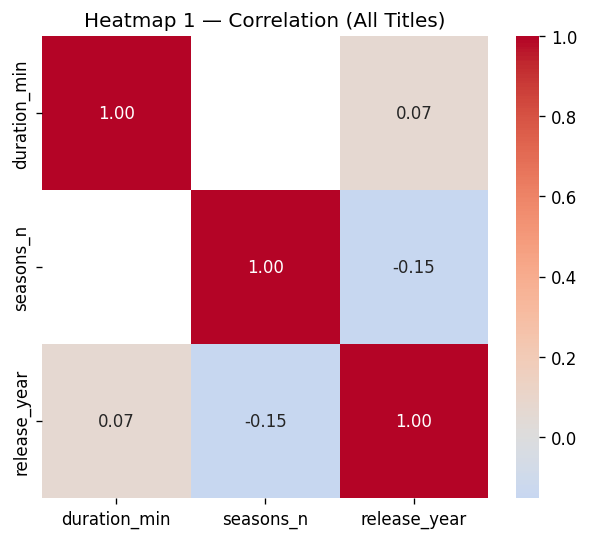

Correlation matrix (Movies only):


,duration_min,release_year,rating_encoded
duration_min,1.000000,0.067449,0.127797
release_year,0.067449,1.000000,0.255525
rating_encoded,0.127797,0.255525,1.000000


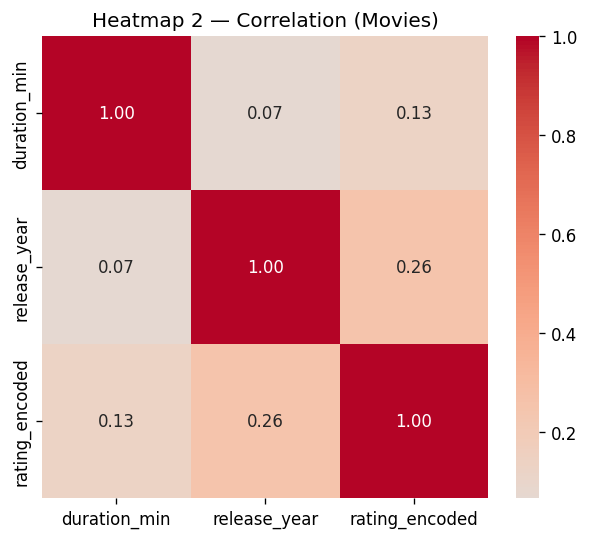

Correlation matrix (TV Shows only):


,seasons_n,release_year,rating_encoded
seasons_n,1.000000,-0.152724,-0.036221
release_year,-0.152724,1.000000,0.190393
rating_encoded,-0.036221,0.190393,1.000000


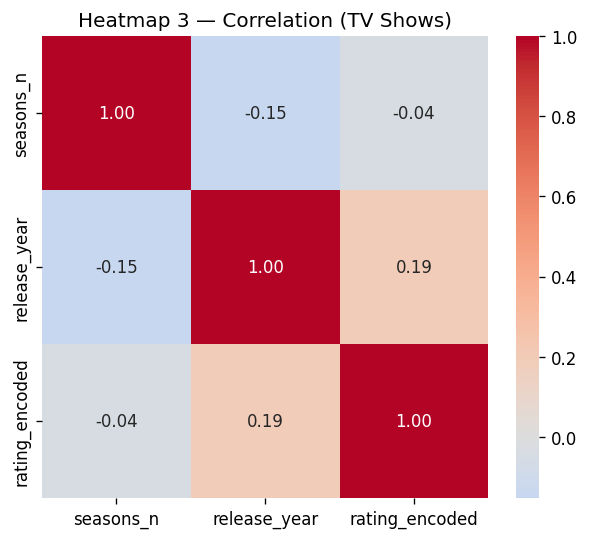

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Encode ratings into ordinal scale
rating_map = {"G": 0, "Teen": 1, "Mature": 2, "Other": 1, "Unknown": np.nan}
df["rating_encoded"] = df["rating_norm"].map(rating_map)

# --- Heatmap 1 (Baseline: All titles) ---
corr_all = df[["duration_min", "seasons_n", "release_year"]].corr()
print("Correlation matrix (All titles):")
display(corr_all)

plt.figure(figsize=(6,5))
sns.heatmap(corr_all, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Heatmap 1 — Correlation (All Titles)")
plt.show()

# --- Heatmap 2 (Movies) ---
movies = df[df["type"].str.lower()=="movie"]
corr_movies = movies[["duration_min", "release_year", "rating_encoded"]].corr()
print("Correlation matrix (Movies only):")
display(corr_movies)

plt.figure(figsize=(6,5))
sns.heatmap(corr_movies, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Heatmap 2 — Correlation (Movies)")
plt.show()

# --- Heatmap 3 (TV Shows) ---
tvshows = df[df["type"].str.lower().isin(["tv show","show","tvshow"])]
corr_tv = tvshows[["seasons_n", "release_year", "rating_encoded"]].corr()
print("Correlation matrix (TV Shows only):")
display(corr_tv)

plt.figure(figsize=(6,5))
sns.heatmap(corr_tv, annot=True, cmap="coolwarm", center=0, fmt=".2f")
plt.title("Heatmap 3 — Correlation (TV Shows)")
plt.show()

### Key Findings — Correlations

- **Heatmap 1 (All Titles):**
  - Very weak positive correlation between `duration_min` and `release_year` (0.07).
  - Weak negative correlation between `seasons_n` and `release_year` (-0.15), suggesting that newer TV shows tend to have slightly fewer seasons.
  - No meaningful relation between `duration_min` and `seasons_n`, as expected (since these belong to different content types).

- **Heatmap 2 (Movies):**
  - Runtime (`duration_min`) shows almost no correlation with release year (0.07).
  - Weak positive correlation between `release_year` and `rating_encoded` (0.26), suggesting that more recent movies tend to have different rating distributions.
  - Runtime and ratings show minimal association (0.13).

- **Heatmap 3 (TV Shows):**
  - Slight negative correlation between number of seasons and release year (-0.15), reinforcing the trend toward shorter series in recent years.
  - Weak positive correlation between `release_year` and `rating_encoded` (0.19), indicating ratings categories shifted over time.
  - Seasons and ratings are not correlated (-0.04), showing rating is not related to show length.

**Overall Insight:**  
Correlations across numeric features are generally weak, meaning structural patterns (like duration or seasons) do not strongly depend on release year or rating. However, small signals suggest modern content tends to have **fewer seasons** (TV shows) and **different rating distributions** (movies and shows).

## 23. Countries of Origin Analysis

We now examine the geographic diversity of the catalogs by analyzing the **country_primary** field.  
This step highlights whether each platform focuses mainly on domestic content or distributes titles from a wide range of international markets.  

We will look at:  
- The top 15 countries of origin overall.  
- A split by platform for these top countries.  
- A diversity snapshot (number of unique countries represented per platform).  
- A stacked bar chart comparing the top-10 countries between Netflix and Disney+.  

,country,count_overall
0,United States,4332
1,India,1010
2,United Kingdom,678
3,Canada,297
4,Japan,259
5,France,222
6,South Korea,212
7,Spain,181
8,Mexico,134
9,Australia,121


platform,Disney+,Netflix
country,,
United States,1121,3211
India,2,1008
United Kingdom,50,628
Canada,26,271
Japan,0,259
France,10,212
South Korea,1,211
Spain,0,181
Mexico,0,134


,platform,unique_countries
0,Disney+,17
1,Netflix,85


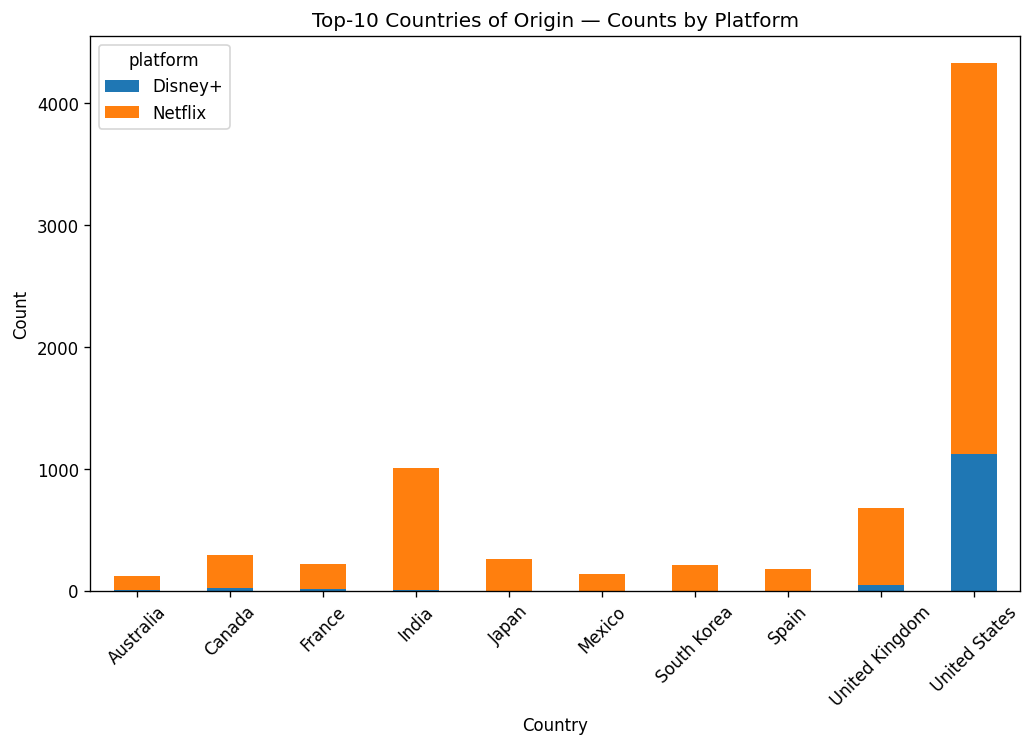

In [50]:
import matplotlib.pyplot as plt

# Table 1 – Overall counts of titles by country (top 15)
table1 = (
    df["country_primary"]
    .value_counts()
    .head(15)
    .rename_axis("country")
    .reset_index(name="count_overall")
)
display(table1.style.set_caption("Table 1 — Top 15 Countries of Origin (Overall)"))

# Table 2 – Counts by platform (restricted to top 15 overall countries)
table2 = (
    df.groupby(["country_primary", "platform"])
    .size()
    .unstack(fill_value=0)
    .reindex(table1["country"])  # keep same top-15 order
)
display(table2.style.set_caption("Table 2 — Top 15 Countries of Origin by Platform"))

# Table 3 – Diversity snapshot (unique countries per platform)
table3 = (
    df.groupby("platform")["country_primary"]
    .nunique()
    .rename("unique_countries")
    .reset_index()
)
display(table3.style.set_caption("Table 3 — Diversity Snapshot per Platform"))

# Visualization — Top 10 countries by counts, split by platform
top_countries = table1["country"].head(10).tolist()
df_top_countries = df[df["country_primary"].isin(top_countries)]

df_top_countries.groupby(["country_primary","platform"]).size().unstack().plot(
    kind="bar", stacked=True, figsize=(10,6)
)
plt.title("Top-10 Countries of Origin — Counts by Platform")
plt.ylabel("Count")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.show()


### Key Findings — Countries of Origin

- The United States overwhelmingly dominates both catalogs, accounting for the majority of titles in Disney+ and Netflix.  
- Netflix shows a much broader international reach, with strong representation from India, the United Kingdom, Japan, South Korea, Spain, and Mexico.  
- Disney+ content is heavily concentrated in U.S. productions, with only minor contributions from other countries (e.g., United Kingdom, Canada, France).  
- Diversity snapshot: Netflix has content from **85 unique countries**, while Disney+ covers only **17 countries**, confirming the broader international sourcing of Netflix.  
- Key insight: This aligns with strategic positioning — Netflix emphasizes global reach and localization, while Disney+ leverages its U.S.-centric, family-oriented legacy content.  

## Step 24 — Themes & Topics Analysis

In this step, we examine the textual descriptions of titles to identify recurring themes and distinctive topics for each platform.  
By applying TF-IDF (Term Frequency–Inverse Document Frequency), we can highlight which words and phrases appear more prominently in Netflix versus Disney+.  
This allows us to move beyond purely quantitative measures (such as runtime or genres) and gain a qualitative view of the catalog strategies.  

We will present the most relevant unigrams (single words) and bigrams (two-word combinations), as well as visual comparisons that show how the platforms differentiate in terms of narrative focus.

,term,score
2604,life,0.014750
3000,new,0.013191
4985,young,0.012863
1642,family,0.012392
4953,world,0.011531
2722,man,0.010458
2669,love,0.009952
1823,friends,0.009703
4933,woman,0.009351
3927,series,0.008323


,term,score
2612,life,0.015233
4986,young,0.013665
3004,new,0.013226
1636,family,0.012472
4953,world,0.011370
2724,man,0.011095
2672,love,0.010529
4935,woman,0.010326
1828,friends,0.009732
3931,series,0.008685


,term,score
997,details,0.017694
84,advisory,0.017566
1043,disney,0.013069
2596,new,0.012355
4212,world,0.011695
1344,family,0.011224
2204,life,0.011092
3267,save,0.009580
1518,friends,0.009471
3726,team,0.008676


,term,score
731,details advisory,0.008593
1307,high school,0.007077
4943,year old,0.006860
4985,young woman,0.005387
4973,young man,0.005229
2870,new york,0.004924
357,best friends,0.003438
4345,small town,0.003369
4721,true story,0.002984
356,best friend,0.002825


,term,score
1313,high school,0.007329
4950,year old,0.006798
4988,young woman,0.005928
4976,young man,0.005713
2901,new york,0.005234
348,best friends,0.003750
4240,small town,0.003673
347,best friend,0.003207
719,documentary follows,0.003202
4940,world war,0.003061


,term,score
1602,details advisory,0.021384
4976,year old,0.004954
3457,high school,0.004642
4907,star wars,0.003329
4956,walt disney,0.003259
3882,join forces,0.002465
1014,chip dale,0.002250
4808,mickey mouse,0.002190
4844,new york,0.002105
490,best friends,0.001914


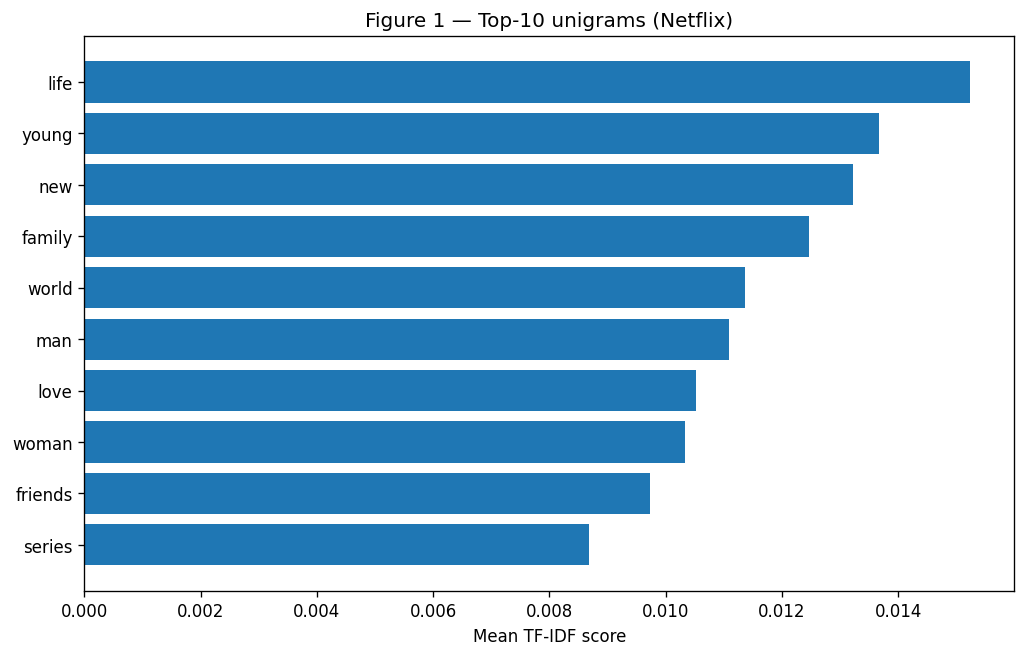

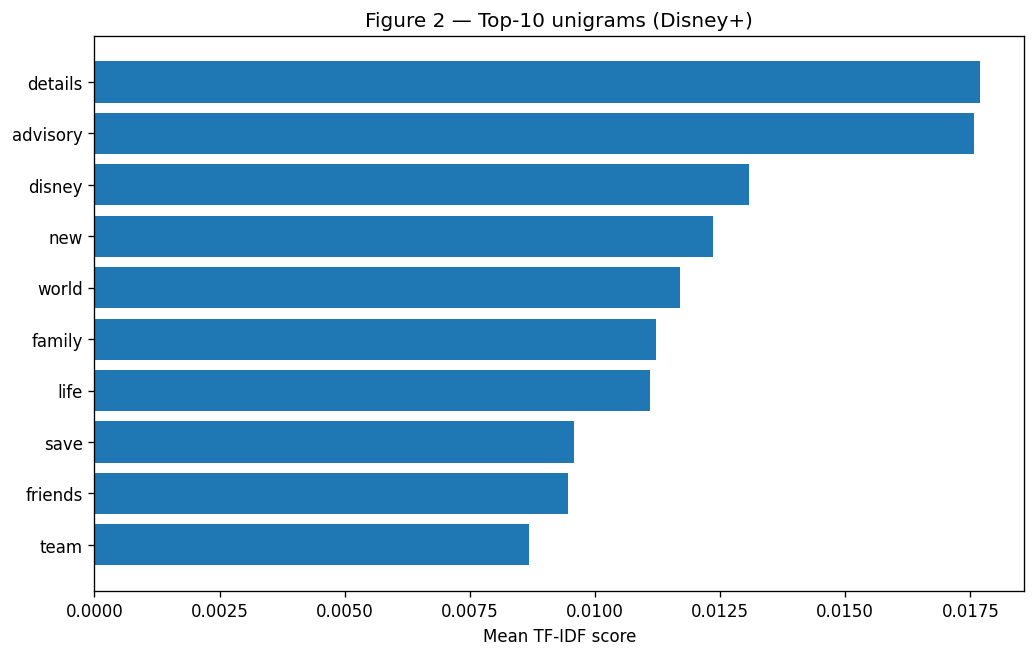

Docs used — Netflix descriptions: 8807
Docs used — Disney+ descriptions: 1450


In [55]:
# ======================
# STEP 24 — THEMES & TOPICS (TF-IDF Analysis)
# ======================

from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd

# Make sure descriptions are filled
df['description'] = df['description'].fillna("")

# --- TF-IDF Vectorizer (Unigrams & Bigrams)
tfidf_uni = TfidfVectorizer(stop_words='english', ngram_range=(1,1), max_features=5000)
tfidf_bi = TfidfVectorizer(stop_words='english', ngram_range=(2,2), max_features=5000)

# --- Fit for overall
tfidf_uni_overall = tfidf_uni.fit_transform(df['description'])
tfidf_bi_overall = tfidf_bi.fit_transform(df['description'])

# --- DataFrames for unigrams and bigrams overall
unigram_overall = pd.DataFrame({
    "term": tfidf_uni.get_feature_names_out(),
    "score": tfidf_uni_overall.mean(axis=0).A1
}).sort_values(by="score", ascending=False)

bigram_overall = pd.DataFrame({
    "term": tfidf_bi.get_feature_names_out(),
    "score": tfidf_bi_overall.mean(axis=0).A1
}).sort_values(by="score", ascending=False)

# --- Subsets by platform
df_netflix = df[df['platform'] == "Netflix"]
df_disney = df[df['platform'] == "Disney+"]

# Netflix
tfidf_uni_netflix = tfidf_uni.fit_transform(df_netflix['description'])
tfidf_bi_netflix = tfidf_bi.fit_transform(df_netflix['description'])

unigram_netflix = pd.DataFrame({
    "term": tfidf_uni.get_feature_names_out(),
    "score": tfidf_uni_netflix.mean(axis=0).A1
}).sort_values(by="score", ascending=False)

bigram_netflix = pd.DataFrame({
    "term": tfidf_bi.get_feature_names_out(),
    "score": tfidf_bi_netflix.mean(axis=0).A1
}).sort_values(by="score", ascending=False)

# Disney+
tfidf_uni_disney = tfidf_uni.fit_transform(df_disney['description'])
tfidf_bi_disney = tfidf_bi.fit_transform(df_disney['description'])

unigram_disney = pd.DataFrame({
    "term": tfidf_uni.get_feature_names_out(),
    "score": tfidf_uni_disney.mean(axis=0).A1
}).sort_values(by="score", ascending=False)

bigram_disney = pd.DataFrame({
    "term": tfidf_bi.get_feature_names_out(),
    "score": tfidf_bi_disney.mean(axis=0).A1
}).sort_values(by="score", ascending=False)

# --- Display Tables (renumbered, clean titles)

from IPython.display import display, HTML

# Unigrams
display(HTML("<h4>Table 1 — Top unigrams (Overall)</h4>"))
display(unigram_overall.head(15))

display(HTML("<h4>Table 2 — Top unigrams (Netflix)</h4>"))
display(unigram_netflix.head(15))

display(HTML("<h4>Table 3 — Top unigrams (Disney+)</h4>"))
display(unigram_disney.head(15))

# Bigrams
display(HTML("<h4>Table 4 — Top bigrams (Overall)</h4>"))
display(bigram_overall.head(15))

display(HTML("<h4>Table 5 — Top bigrams (Netflix)</h4>"))
display(bigram_netflix.head(15))

display(HTML("<h4>Table 6 — Top bigrams (Disney+)</h4>"))
display(bigram_disney.head(15))

# --- Visualization (Top-10 unigrams per platform)

# Netflix
plt.figure(figsize=(10,6))
plt.barh(unigram_netflix.head(10)['term'][::-1], unigram_netflix.head(10)['score'][::-1])
plt.title("Figure 1 — Top-10 unigrams (Netflix)")
plt.xlabel("Mean TF-IDF score")
plt.show()

# Disney+
plt.figure(figsize=(10,6))
plt.barh(unigram_disney.head(10)['term'][::-1], unigram_disney.head(10)['score'][::-1])
plt.title("Figure 2 — Top-10 unigrams (Disney+)")
plt.xlabel("Mean TF-IDF score")
plt.show()

# --- Print counts for traceability
print(f"Docs used — Netflix descriptions: {len(df_netflix)}")
print(f"Docs used — Disney+ descriptions: {len(df_disney)}")


### Key Findings — Themes & Topics

- Across all titles, the most common unigrams include **life, new, young, family, world, man, love, friends, woman, and series**, highlighting recurring narrative elements centered on **human relationships, youth, and universal themes**.  
- Netflix's top terms closely mirror the overall distribution (e.g., **life, young, new, family, world**), reflecting its broader and more diversified catalog.  
- Disney+ shows a distinct profile: terms like **details, advisory, disney, team, save, mickey, marvel** stand out, underscoring **brand-driven and franchise-oriented storytelling**.  
- Bigram analysis reinforces these differences:  
  - Netflix emphasizes real-world contexts and social settings (**high school, young woman, new york, world war, small town, best friends**).  
  - Disney+ emphasizes franchise universes and brand-specific themes (**star wars, walt disney, chip dale, marvel studios, mickey mouse, national geographic**).  
- The contrast suggests that **Netflix positions itself as a platform with broad, relatable stories spanning multiple cultures**, while **Disney+ leverages iconic franchises and family-oriented branding** to differentiate its catalog.  
- This qualitative layer complements earlier findings on genres and countries, showing that **platform identity is not only numerical (catalog size, genre counts) but also linguistic, embedded in how stories are framed**.

## Step 25 — Platform Positioning Summary

Here I synthesize the quantitative and qualitative evidence into a clear positioning view for both platforms.  
The goal is to condense catalog **scale**, **mix** (movies vs. TV), **format profile** (runtime / seasons), **diversity** (genres, countries), **age-rating stance**, and **narrative themes** into a compact snapshot that supports strategic takeaways.  

Below I generate a small KPI table (one row per platform) and a simple rating mix view.  
You’ll use this to write the final executive summary and recommendations.

,platform,titles_total,movie_share,median_movie_runtime_min,median_tv_seasons,unique_primary_genres,avg_genre_count_per_title,unique_countries,rating_G_share,rating_Teen_share,rating_Mature_share,rating_other_share
0,Disney+,1450,0.726,85.0,1.0,29,2.697,17,0.810,0.054,0.000,0.136
1,Netflix,8807,0.696,98.0,1.0,36,2.194,85,0.216,0.245,0.464,0.075


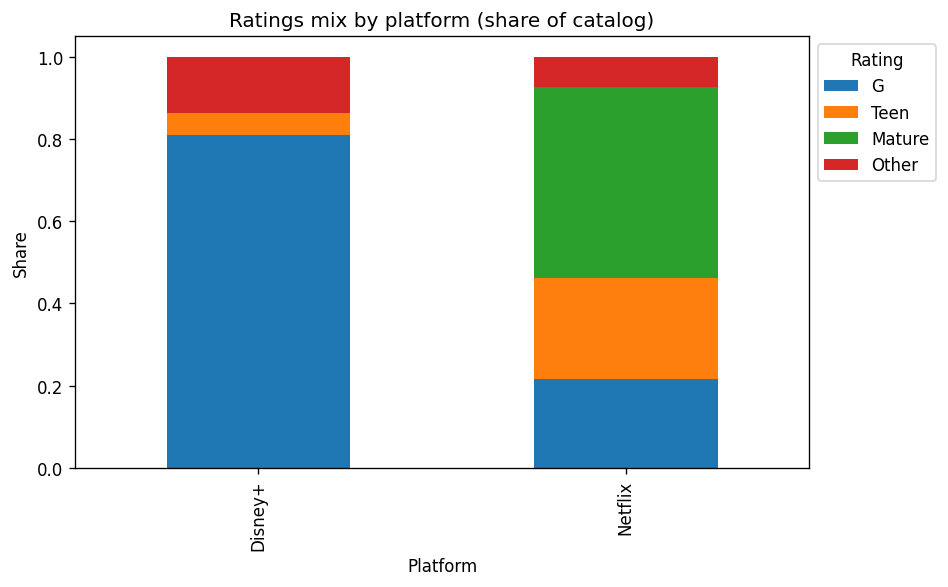

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def med(s):
    return float(np.nanmedian(s)) if len(s) else np.nan

kpis = []

for p, g in df.groupby("platform"):
    # scale
    total = len(g)
    movies = (g["type"].str.lower()=="movie").sum()
    shows  = (g["type"].str.lower().isin(["tv show","tvshow","show"])).sum()
    movie_share = movies / total if total else np.nan

    # format profile
    med_runtime = med(g.loc[g["type"].str.lower()=="movie","duration_min"])
    med_seasons = med(g.loc[g["type"].str.lower().isin(["tv show","tvshow","show"]),"seasons_n"])

    # diversity
    uniq_genres   = g["primary_genre"].dropna().nunique()
    avg_genre_cnt = float(g["genre_count"].dropna().mean()) if "genre_count" in g else np.nan
    uniq_countries= g["country_primary"].dropna().nunique()

    # ratings mix
    rating_counts = g["rating_norm"].fillna("Unknown").value_counts(dropna=False)
    rating_share_g     = rating_counts.get("G",0)/total
    rating_share_teen  = rating_counts.get("Teen",0)/total
    rating_share_mature= rating_counts.get("Mature",0)/total
    rating_other       = 1 - (rating_share_g + rating_share_teen + rating_share_mature)

    kpis.append({
        "platform": p,
        "titles_total": total,
        "movie_share": round(movie_share,3),
        "median_movie_runtime_min": med_runtime,
        "median_tv_seasons": med_seasons,
        "unique_primary_genres": int(uniq_genres),
        "avg_genre_count_per_title": round(avg_genre_cnt,3) if not np.isnan(avg_genre_cnt) else np.nan,
        "unique_countries": int(uniq_countries),
        "rating_G_share": round(rating_share_g,3),
        "rating_Teen_share": round(rating_share_teen,3),
        "rating_Mature_share": round(rating_share_mature,3),
        "rating_other_share": round(rating_other,3),
    })

kpi_df = pd.DataFrame(kpis).sort_values("platform").reset_index(drop=True)

# Pretty display
from IPython.display import display, HTML
display(HTML("<h4>Table — Platform Positioning KPIs</h4>"))
display(kpi_df)

# Optional: stacked bars for rating stance
ratings_long = (
    kpi_df.melt(id_vars=["platform","titles_total"],
                value_vars=["rating_G_share","rating_Teen_share","rating_Mature_share","rating_other_share"],
                var_name="rating", value_name="share")
    .assign(rating=lambda d: d["rating"].str.replace("rating_","").str.replace("_share","").str.title())
)

pivot = ratings_long.pivot(index="platform", columns="rating", values="share").fillna(0.0)[["G","Teen","Mature","Other"]]
ax = pivot.plot(kind="bar", stacked=True, figsize=(8,5))
ax.set_title("Ratings mix by platform (share of catalog)")
ax.set_ylabel("Share")
ax.set_xlabel("Platform")
plt.legend(title="Rating", bbox_to_anchor=(1.0,1.0))
plt.tight_layout()
plt.show()


### Key Findings — Platform Positioning Summary  

- **Catalog size:** Netflix offers a significantly larger library (8,807 titles) compared to Disney+ (1,450 titles).  
- **Content mix:** Disney+ leans slightly more toward movies (72.6% share) than Netflix (69.6%).  
- **Runtime & seasons:** Median runtime for movies is longer on Netflix (98 min vs. 85 min), while both platforms have a median of one season for TV shows.  
- **Genre diversity:** Netflix covers more unique primary genres (36 vs. 29), but Disney+ shows higher genre diversity per title (2.70 vs. 2.19).  
- **Country diversity:** Netflix is far more international, spanning 85 unique countries compared to Disney+’s 17.  
- **Ratings mix:** Disney+ overwhelmingly focuses on G-rated content (81%), reflecting its family orientation. Netflix has a broader spread, with a large share of Mature (46%) and Teen (25%) content.  

# Conclusions and Insights  

This comparative analysis of Netflix and Disney+ catalogs has revealed a series of important insights that go far beyond simple counts of titles. By combining quantitative exploration (runtimes, genres, countries, ratings) with qualitative text mining (themes and keywords), we have gained a holistic view of how each platform positions itself and differentiates its content strategy.  

**Scale and Structure**  
The first observation is the sheer difference in scale. Netflix, with nearly 9,000 titles, clearly operates as a global, high-volume distributor. Disney+, by contrast, offers a much smaller catalog of around 1,500 titles. This difference in scale immediately frames how the platforms compete: Netflix emphasizes variety and availability, while Disney+ emphasizes selectivity and brand curation. Both lean toward movies as their dominant format, but the relative proportions highlight subtle differences—Disney+ invests more heavily in movies, while Netflix balances its catalog with a larger share of TV shows.  

**Runtime and Seasons**  
When looking at runtimes, the difference is subtle but meaningful. Netflix movies tend to run longer, with a median runtime close to 100 minutes, compared to around 85 minutes on Disney+. This reinforces the idea that Netflix carries a wide spectrum of films, from short features to long-form cinema. On the TV side, both platforms show the same trend: modern series often last only one season. This reflects broader industry dynamics, where short, binge-worthy shows are easier to produce, easier to market, and fit consumer habits of quick, intensive viewing.  

**Genres and Diversity**  
The genre breakdown highlights another important contrast. Netflix covers a wider range of primary genres (36 unique genres versus 29 on Disney+), which fits its positioning as a platform that wants to “have something for everyone.” Disney+, however, shows higher genre density per title—each title is associated with more genres on average. This suggests that Disney’s catalog, while smaller, has more complex tagging and tends to mix themes (for example, an animated film that is also tagged as family, adventure, and musical). In practice, this means Netflix achieves diversity through **breadth**, while Disney+ achieves it through **depth within carefully chosen categories**.  

**Geographic Reach**  
Perhaps the starkest difference appears in the country of origin. Netflix draws from 85 unique countries, signaling a genuine global reach. Its strategy clearly embraces international productions, co-productions, and regional storytelling. Disney+, on the other hand, is strongly U.S.-centric, with only 17 countries represented. For audiences, this means Netflix is more likely to deliver local stories in different markets, while Disney+ doubles down on U.S. content and its internationally recognized franchises.  

**Ratings and Audience Targeting**  
The ratings distribution is perhaps the clearest single marker of strategic intent. Disney+ is overwhelmingly family-oriented: more than 80% of its catalog is rated G, and there are essentially no Mature-rated titles. Netflix, in contrast, has a balanced distribution with a very strong Mature segment (around 46% of its content), plus a significant share for Teen audiences. This demonstrates that Netflix actively caters to adults as well as families, whereas Disney+ deliberately maintains its “safe space” for children and family viewing. This choice not only shapes the catalog but also reinforces brand perception: Disney+ is a family-first service, while Netflix is an all-audience global service.  

**Themes and Storytelling**  
The TF-IDF analysis of descriptions provided a qualitative angle that strongly complements the numeric data. Netflix’s descriptions tend to highlight everyday life, young characters, relationships, and social contexts. Phrases like *young woman*, *small town*, and *high school* suggest a focus on relatable, human-centered stories across cultures. Disney+, by contrast, surfaces terms that are almost synonymous with its brand identity: *Star Wars, Marvel Studios, Mickey Mouse, National Geographic.* In other words, Disney+ descriptions are dominated by **intellectual properties and franchises** that already have global recognition. This duality is powerful: Netflix positions itself as the platform of human diversity and global storytelling, while Disney+ positions itself as the home of universally known brands and safe adventures.  

**Strategic Positioning**  
Bringing all these findings together, the positioning becomes clear. Netflix leverages **scale, diversity, and internationalization**. It offers something for every age group, every region, and every taste, even if that means a heterogeneous and less curated catalog. Disney+, meanwhile, leverages **brand equity, safety, and focus**. Its smaller catalog is not a weakness but a deliberate strategy: fewer titles, but each tied to powerful franchises and a family-friendly guarantee.  

**Final Reflection**  
For recruiters or stakeholders, this project shows how exploratory data analysis can illuminate not only “what is in the data” but also “what it means strategically.” Through 25 steps, we moved from raw cleaning and preparation to visualizations, correlations, keyword extraction, and strategic synthesis. The lesson is that data analysis is not only about counts or averages, but about building a narrative that helps decision-makers understand the *why* behind the numbers.  

Netflix and Disney+ are not direct substitutes; they embody complementary strategies. Netflix thrives on **global scale and variety**, while Disney+ thrives on **trust and branded experiences**. Together, these insights show how numbers, charts, and words can converge into a coherent strategic picture—one that not only tells us about two streaming platforms but also about how data can be transformed into insight.  
